In [7]:
# MODEL = "meta-llama/Llama-2-7b-hf"
MODEL = "meta-llama/Meta-Llama-3.1-8B"
BASE_PPL = 5.606692790985107

In [1]:
from transformers import AutoModelForCausalLM

model_pt = AutoModelForCausalLM.from_pretrained(
    '/mnt/LLM/hub/models--meta-llama--Meta-Llama-3.1-8B/snapshots/13f04ed6f85ef2aa2fd11b960a275c3e31a8069e/',
    trust_remote_code=True, torch_dtype="auto", device_map='meta',
)

def get_module_by_path(model, path):
    if path == '':
        return model
    splitted = path.split('.', 1)
    if len(splitted) == 1:
        splitted.append('')
    next_name, suffix = splitted

    try:
        next_module = model[int(next_name)]
    except:
        next_module = getattr(model, next_name)

    return get_module_by_path(next_module, suffix)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [2]:
import functools


@functools.cache
def get_numel(path):
    return get_module_by_path(model_pt, path).weight.numel()

total_params = sum(p.numel() for p in model_pt.model.layers.parameters())

In [3]:
import tqdm
import pandas as pd 
import wandb
import functools


@functools.cache
def get_df_from_wandb(path):
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(path)
    
    data_df_lines = []
    for run in tqdm.tqdm(runs): 
        data_df_lines.append({
            'Name': run.name,
            'Commit': run.commit,
            **run.summary._json_dict,
            **{k: v for k,v in run.config.items() if not k.startswith('_')},
        })
    data_df = pd.DataFrame(data_df_lines)
    return data_df

In [8]:
# data_df = get_df_from_wandb('rock-and-roll/NOISY_MSE_ONE_LINEAR_LAYER_GALQIWI_PPL')
data_df = pd.read_csv('/tmp/galqiwi/NOISY_MSE_ONE_LINEAR_LAYER_GALQIWI_PPL.csv')

data_df['layer'] = data_df['layer_name']
data_df['mse'] = data_df['relative_mse']

data_df = data_df[data_df['base_model'] == MODEL]

data_df = data_df[['layer', 'mse', 'wikitext2']]
data_df = data_df.dropna().copy()

from sklearn.linear_model import LinearRegression

layers = sorted(set(data_df['layer']))

scale_by_layer = {}
intercept_by_layer = {}

for layer_idx, layer in enumerate(layers):
    to_fit = data_df[data_df['layer'] == layer]
    to_fit = to_fit[to_fit['mse'] < 4 ** -1.7]
    # to_fit = to_fit[to_fit['wikitext2'] < 5.640]

    slope = LinearRegression(fit_intercept=False).fit(to_fit['mse'].values.reshape(-1, 1), to_fit['wikitext2'] - BASE_PPL).coef_
    
    scale_by_layer[layer] = slope.item()
    intercept_by_layer[layer] = BASE_PPL

/var/tmp/ipykernel_534885/2033343197.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv('/tmp/galqiwi/NOISY_MSE_ONE_LINEAR_LAYER_GALQIWI_PPL.csv')


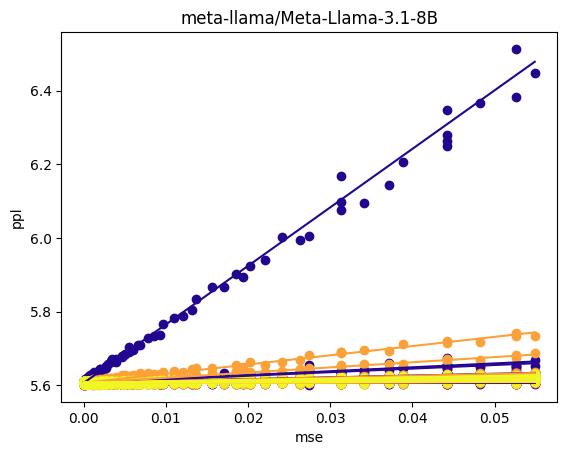

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


cmap = matplotlib.colormaps["plasma"]

for layer_idx, layer in enumerate(layers):
    to_plot = data_df[data_df['layer'] == layer]
    to_plot = to_plot[to_plot['mse'] < 4 ** -2]
    # to_plot = to_plot[to_plot['wikitext2'] < 5.640]
    
    plt.scatter(to_plot['mse'], to_plot['wikitext2'], color=cmap(layer_idx / len(layers)))

    grid = np.linspace(to_plot['mse'].min(), to_plot['mse'].max(), 10)
    
    plt.plot(grid, intercept_by_layer[layer] + grid * scale_by_layer[layer], color=cmap(layer_idx / len(layers)))


plt.title(f'{MODEL}')
plt.xlabel('mse')
plt.ylabel('ppl')
plt.savefig(f'ppl_mse.png')

In [11]:
pd.DataFrame(scale_by_layer.items()).sort_values(1).tail(5)

,0,1
13,model.layers.1.self_attn.v_proj,0.972215
6,model.layers.0.self_attn.v_proj,1.059919
177,model.layers.31.mlp.up_proj,1.402942
175,model.layers.31.mlp.down_proj,2.501540
7,model.layers.1.mlp.down_proj,15.888047


In [12]:
import json

with open('scales.json', 'w') as file:
    json.dump(scale_by_layer, file)

In [13]:
pd.DataFrame(scale_by_layer.items(), columns=['layer', 'scale']).sort_values('scale')

,layer,scale
3,model.layers.0.self_attn.k_proj,-0.003867
5,model.layers.0.self_attn.q_proj,-0.000057
108,model.layers.22.self_attn.k_proj,0.041138
80,model.layers.19.self_attn.k_proj,0.046756
94,model.layers.20.self_attn.k_proj,0.048883
...,...,...
13,model.layers.1.self_attn.v_proj,0.972215
6,model.layers.0.self_attn.v_proj,1.059919
177,model.layers.31.mlp.up_proj,1.402942
175,model.layers.31.mlp.down_proj,2.501540


In [15]:
import requests
from ast import literal_eval
import pandas as pd

grids = literal_eval(requests.get(
    'https://gist.githubusercontent.com/BlackSamorez/c74f24a648eb8bbfbbbf83f3145ba3c7/raw/ddc3280a4861938e2e2034c29d6802817e26e799/gistfile1.txt'
).text)

grids.append({
    'edenn_d': -1,
    'edenn_n': -1,
    'bits': 16,
    'mse': 0.0,
})

grids = pd.DataFrame(grids)
grids['name'] = grids.apply(
    lambda row: 'edenn_d=' + str(row['edenn_d']) + ';edenn_n=' + str(row['edenn_n']),
    axis=1,
)
grids = grids[['bits', 'mse', 'name', 'edenn_d', 'edenn_n']]
print(len(grids))
grids.sample(3)

76


,bits,mse,name,edenn_d,edenn_n
38,1.5,0.183415,edenn_d=4.0;edenn_n=64.0,4,64
33,2.0,0.095966,edenn_d=4.0;edenn_n=256.0,4,256
25,4.0,0.006948,edenn_d=3.0;edenn_n=4096.0,3,4096


In [14]:
from ortools.linear_solver import pywraplp

def find_grids_with_budget(
    slopes,    # linear coefficients for [layerwise mse -> metric]
    weights,   # linear coefficients for [layer bitwidth -> total bitwidth] (1 / num_blocks for blockwise)
    budget,    # upper bound on total bitwidth
    grid_bits, # available grid bitwidths
    grid_mses  # available grid mses
) -> tuple[float, list]:
    num_layers = len(slopes)
    num_grids = len(grid_bits)
    assert len(grid_mses) == num_grids
    
    solver = pywraplp.Solver.CreateSolver("CP-SAT")

    x = {(j, i) : solver.BoolVar("name") for i in range(num_grids) for j in range(num_layers)}
    
    for j in range(num_layers) : solver.Add(sum(x[(j, i)] for i in range(num_grids)) == 1)
    solver.Add(sum(x[(j, i)] * weights[j] * grid_bits[i] for j in range(num_layers) for i in range(num_grids)) <= budget)
    solver.Minimize(sum(x[(j, i)] * slopes[j] * grid_mses[i] for j in range(num_layers) for i in range(num_grids)))

    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        avg_bits = sum(x[(j, i)].solution_value() * weights[j] * grid_bits[i] for j in range(num_layers) for i in range(num_grids))
        solution = np.asarray([[x[(j, i)].solution_value() for i in range(num_grids)] for j in range(num_layers)])
        indices = np.argwhere(solution == 1.0)
        assert len(indices) == num_layers
        return avg_bits, indices[:,1]
    else:
        raise Exception("Didn't solve")

In [46]:
ok_grids = grids
# ok_grids = ok_grids[ok_grids['bits'] >= 2.2]

# HIGGS
# ok_grids = ok_grids[ok_grids['edenn_n'] == 256]
# ok_grids = ok_grids[ok_grids['bits'] >= 1.4]

# FLUTE
ok_grids = ok_grids[ok_grids['edenn_d'] == 1]
ok_grids = ok_grids[
    (ok_grids['edenn_n'] == 4) |
    (ok_grids['edenn_n'] == 8) |
    (ok_grids['edenn_n'] == 16)
]

ok_grids

,bits,mse,name,edenn_d,edenn_n
0,4.0,0.009693,edenn_d=1.0;edenn_n=16.0,1,16
3,2.0,0.116292,edenn_d=1.0;edenn_n=4.0,1,4
5,3.0,0.034860,edenn_d=1.0;edenn_n=8.0,1,8


In [47]:
layers = sorted(layers)

scales = [scale_by_layer[layer] for layer in layers]
numels = [get_numel(layer) for layer in layers]
grid_names=ok_grids['name'].values
grid_bits=ok_grids['bits'].values
grid_mses=ok_grids['mse'].values

solution_size, solution_idxs = find_grids_with_budget(
    scales,
    numels,
    budget=sum(numels) * 3,
    grid_bits=ok_grids['bits'].values,
    grid_mses=ok_grids['mse'].values,
)

print(f'{solution_size / sum(numels)} bits')

3.0 bits


In [48]:
optimal_by_layer = dict(zip(layers, [grid_names[idx] for idx in solution_idxs]))

In [49]:
layer_idx = 0

def to_list(name):
    return [round(float(x.split('=')[-1])) for x in name.split(';')]

output = []

for layer_idx in range(32):
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.self_attn.q_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.self_attn.k_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.self_attn.v_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.self_attn.o_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.mlp.gate_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.mlp.up_proj']))
    output.append(to_list(optimal_by_layer[f'model.layers.{layer_idx}.mlp.down_proj']))

print(output)

[[1, 4], [1, 4], [1, 16], [1, 8], [1, 4], [1, 4], [1, 8], [1, 8], [1, 8], [1, 16], [1, 16], [1, 4], [1, 8], [1, 16], [1, 8], [1, 16], [1, 16], [1, 8], [1, 8], [1, 8], [1, 8], [1, 8], [1, 16], [1, 16], [1, 8], [1, 8], [1, 8], [1, 8], [1, 8], [1, 16], [1, 16], [1, 8], [1, 8], [1, 8], [1, 8], [1, 8], [1, 16], [1, 16], [1, 8], [1, 8], [1, 8], [1, 8], [1, 8], [1, 16], [1, 16], [1, 8], [1, 8], [1, 8], [1, 8], [1, 8], [1, 16], [1, 16], [1, 16], [1, 4], [1, 8], [1, 8], [1, 8], [1, 16], [1, 16], [1, 16], [1, 4], [1, 8], [1, 8], [1, 8], [1, 16], [1, 16], [1, 16], [1, 4], [1, 8], [1, 8], [1, 8], [1, 16], [1, 16], [1, 16], [1, 4], [1, 8], [1, 8], [1, 16], [1, 16], [1, 16], [1, 16], [1, 4], [1, 8], [1, 8], [1, 8], [1, 16], [1, 16], [1, 16], [1, 4], [1, 8], [1, 8], [1, 8], [1, 16], [1, 16], [1, 16], [1, 4], [1, 8], [1, 8], [1, 16], [1, 16], [1, 16], [1, 16], [1, 8], [1, 8], [1, 8], [1, 8], [1, 16], [1, 16], [1, 16], [1, 8], [1, 8], [1, 8], [1, 8], [1, 16], [1, 16], [1, 16], [1, 8], [1, 8], [1, 8], [

In [223]:
len(output)

224

In [27]:
!git add . && git commit -m 'linear-layer-compression' && git push

[galqiwi 085d547] linear-layer-compression
 2 files changed, 1543 insertions(+)
 create mode 100644 Vladimir/2024-09-03/lienar-layer-compression/.ipynb_checkpoints/values-checkpoint.ipynb
 create mode 100644 Vladimir/2024-09-03/lienar-layer-compression/values.ipynb
Counting objects: 7, done.
Delta compression using up to 255 threads.
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 55.98 KiB | 14.00 MiB/s, done.
Total 7 (delta 0), reused 0 (delta 0)
To github.com:galqiwi/linear-layer-compression.git
   bf437c9..085d547  galqiwi -> galqiwi
